<a href="https://colab.research.google.com/github/wakamatsuikuma/MEMO_causal_analysis_by_python/blob/main/7_5_PC%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%AB%E3%82%88%E3%82%8B%E3%83%99%E3%82%A4%E3%82%B8%E3%82%A2%E3%83%B3%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AE%E5%AE%9F%E8%A3%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要
## ベイジアンネットワークでの因果探索
【因果探索に用いるベイジアンネットワークは大きく3タイプ】  
1. スコアリングによる構造学習：さまざまなDAGに対してスコア(*1)を求め、最も指標値の良いDAGを選ぶ  
    *1 観測データに対するネットワークの当てはまりの良さを示すスコア：AIC, BIC, MDL符号, BDe, BDeu, K2
2. 条件付き独立性検定による構造学習：以下の流れで求める  
    ① 変数間の独立性検定を各条件付きパターンで繰り返して、スケルトン構造を同定  
    ② オリエンテーションルールで部分的に方向づけを繰り返してPDAG(Partially DAG)をつくる  
    ③ ②を繰り返してDAGを推定  
3. ハイブリッド型構造型学習：スコアリングと条件付き独立性検定を組み合わせたもの  
    代表的な手法に、MMHCアルゴリズム(Max-Min Hill Climbing alcorithm)がある。  
    
今回は2を実装。  
  
## ベイジアンネットワークでの推論  
ベイジアンネットワークをベースに未観測データの値を推論する手法は複数ある  
  -> 今回は、変数消去アルゴリズム(*1)をライブラリで実装
  
  *1 確率分布を変形手法である周辺化を利用して変数を消去して推論  


【コーディングのイメージ】  
1. BaysianModel()=ベイジアンモデルに因果モデルを与える（変数(カラム)を指定。）
2. BaysianModel().fit()で観測データを与える
3. VariableElimination(BaysianModel()).query()に推論したい変数(=カラム)と観測できているデータ(カラム=変数とデータ)を与える  
  -> 未観測変数の値を確率的に推定できる

フォローできていないところ  
- 独立性の検定のカイ二乗以外の他手法
- オリエンテーションルールの原理

# プログラム実行前の設定など

In [ ]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)

In [ ]:
# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *

# グラフの描画用
import matplotlib.pyplot as plt

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# シグモイド関数をimport
from scipy.special import expit

# その他
import pandas as pd

# 上記②について：PCアルゴリズムによるベイジアンネットワーク探索の実装

## データの生成

Z <- x -> Y  
Z -> Y  
Y -> Y3 <- Y2  
Y3 -> Y4  
の構造をもつデータを生成する

In [ ]:
# データ数
num_data = 2000

# x : 部下育成の熱心さ。-1から1の一様乱数
x = np.random.uniform(low=-1, high=1, size=num_data)

# Z : 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
# z_prob = expit(5.0*x+5*e_z) # シグモイド関数により受講するかどうかを熱心さに影響を受ける確率で表現(あくまで確率)
z_prob = expit(6.0*x+5*e_z)
Z = np.array([])
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0] # 
    Z = np.append(Z, Z_i)

# Y : 部下の面談の満足度
# 研修の効果は熱心さで効果が変わってくるとする(介入効果の非線形性)
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0
e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.2*e_y

# Y2 : 部下当人へのチームメンバジェの満足度1から5の5段階
Y2 = np.random.choice([1.0, 2.0, 3.0, 4.0, 5.0],
                      num_data, p=[0.1, 0.2, 0.3, 0.2, 0.2])

# Y3 : 部下当人への仕事への満足度
e_y3 = randn(num_data)
Y3 = 5*Y + 2*Y2 + e_y3

# Y4 : 部下当人の仕事のパフォーマンス
e_y4 = randn(num_data)
Y4 = 3*Y3 + 5 + 2*e_y4 


In [ ]:
# データテーブルとして作成
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   'Y2': Y2,
                   'Y3': Y3,
                   'Y4': Y4,
                   })

df.head()  # 先頭を表示


,x,Z,t,Y,Y2,Y3,Y4
0,-0.616961,0.0,0.5,1.758937,2.0,12.666456,42.128242
1,0.244218,1.0,0.7,2.956007,3.0,19.930087,64.707398
2,-0.124545,0.0,0.5,2.434394,3.0,19.145587,64.210457
3,0.570717,1.0,1.0,3.289929,3.0,22.070455,72.983015
4,0.559952,1.0,1.0,3.750548,5.0,28.793678,89.958753


## データを可視化（育成の熱心さに対して）

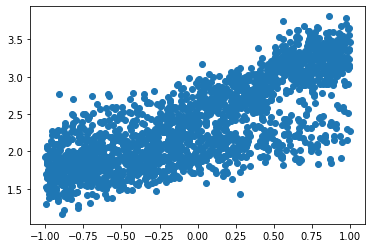

In [ ]:
# グラフで確認
plt.scatter(x, Y)

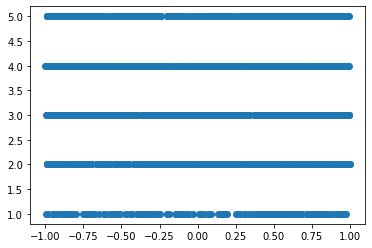

In [ ]:
# グラフで確認
plt.scatter(x, Y2)

- 実際は影響しそうだけ、今回は因果がないとしてデータ生成

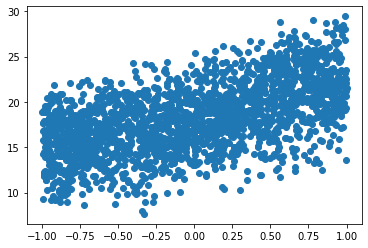

In [ ]:
# グラフで確認
plt.scatter(x, Y3)

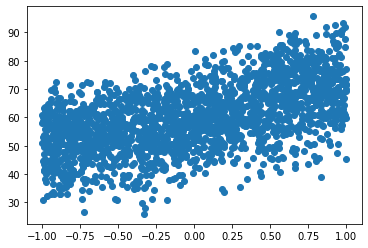

In [ ]:
# グラフで確認
plt.scatter(x, Y4)

## データの離散化(ビンで区切る)

In [ ]:
# cut(閾値を等分で決める)とqcut(各ビンのデータ数が同じになるように決める)がある
s_qcut, bins = pd.cut(df["Y"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

print(s_qcut)
print("=========")
print(bins)

0       2
1       4
2       3
3       5
4       5
       ..
1995    2
1996    4
1997    4
1998    4
1999    4
Name: Y, Length: 2000, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]
[1.16273463 1.69391091 2.22244452 2.75097813 3.27951174 3.80804535]


In [ ]:
for i in range(1, 6):
  print(len(s_qcut[s_qcut == i]))

195
771
447
438
149


<AxesSubplot:>

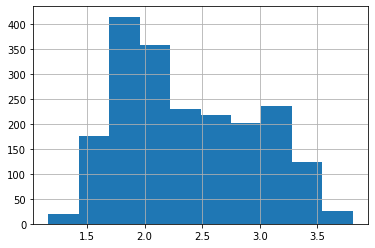

In [ ]:
df["Y"].hist()

In [ ]:
df.head()

,x,Z,t,Y,Y2,Y3,Y4
0,-0.616961,0.0,0.5,1.758937,2.0,12.666456,42.128242
1,0.244218,1.0,0.7,2.956007,3.0,19.930087,64.707398
2,-0.124545,0.0,0.5,2.434394,3.0,19.145587,64.210457
3,0.570717,1.0,1.0,3.289929,3.0,22.070455,72.983015
4,0.559952,1.0,1.0,3.750548,5.0,28.793678,89.958753


In [ ]:
df["Z"].value_counts()

0.0    1006
1.0     994
Name: Z, dtype: int64

In [ ]:
df_bin = df.copy()
del df_bin["t"]

# x:部下育成への熱心さ
df_bin["x"], x_bins = pd.cut(df["x"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Z:上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
df_bin["Z"], Z_bins = pd.cut(df["Z"], 2, labels=[0, 1], retbins=True)

# Y:部下の面談の満足度
df_bin["Y"], Y_bins = pd.cut(df["Y"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Y2：部下当人のチームメンバへの満足度 1から5の5段階
# # ※qcutではなく、cutで値に応じて分割
df_bin["Y2"], y2_bins = pd.cut(
    df["Y2"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Y3：部下当人の仕事への満足度
df_bin["Y3"], y3_bins = pd.cut(
    df["Y3"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Y4：部下当人の仕事のパフォーマンス
df_bin["Y4"], y4_bins = pd.cut(
    df["Y4"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# 確認
df_bin.head()

,x,Z,Y,Y2,Y3,Y4
0,1,0,2,2,2,2
1,4,1,4,3,3,3
2,3,0,3,3,3,3
3,4,1,5,3,4,4
4,4,1,5,5,5,5


In [ ]:
for col_name in df_bin.columns:
  print(f"カラム名：{col_name}")
  display(df_bin[col_name].value_counts())
  print("=====")

カラム名：x


1    452
5    414
3    410
4    381
2    343
Name: x, dtype: int64

=====
カラム名：Z


0    1006
1     994
Name: Z, dtype: int64

=====
カラム名：Y


2    771
3    447
4    438
1    195
5    149
Name: Y, dtype: int64

=====
カラム名：Y2


3    599
2    407
4    405
5    390
1    199
Name: Y2, dtype: int64

=====
カラム名：Y3


3    840
2    544
4    436
1     97
5     83
Name: Y3, dtype: int64

=====
カラム名：Y4


3    876
2    538
4    431
1     86
5     69
Name: Y4, dtype: int64

=====


# PCアルゴリズムを実施

## まずは独立性の検定

In [ ]:
!pip install pgmpy==0.1.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.7/331.7 KB 7.8 MB/s eta 0:00:00


In [ ]:
from pgmpy.estimators import ConstraintBasedEstimator

est = ConstraintBasedEstimator(df_bin)

# 0次の独立性の検定
# 指定するもの：調べたい2変数(2カラム)、検定の手法（今回はカイ二乗検定）、閾値(p値？)
# 6カラムあるので、組み合わせは5+4+3+2+1=15通り

print(est.test_conditional_independence(
    "x", "Z", method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y2', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Z', 'Y', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y2', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Y', 'Y2', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Y2', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y2', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Y3', 'Y4', method="chi_square", tol=0.05))
print("=====")

False
False
True
False
False
=====
False
True
False
False
=====
True
False
False
=====
False
False
=====
False
=====


Falseならエッジでつなぐ

In [ ]:
# 1次の独立性の検定　
# 指定するもの：調べたい2変数(2カラム)、固定したい1変数(カラム)、検定の手法（今回はカイ二乗検定）、閾値(p値？)
# 0次の独立性の検定で関連があったものに対して選ぶ

# 変数xについて：xは4変数と関連があったので、4*3=12通り
print(est.test_conditional_independence(
    'x', 'Z', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Z', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Z', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'x', 'Y', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'x', 'Y3', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y3', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y3', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'x', 'Y4', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y4', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y4', ['Y3'], method="chi_square", tol=0.05))


False


/usr/local/lib/python3.8/dist-packages/pgmpy/estimators/CITests.py:112: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  XZ_state_counts = XYZ_state_counts.sum(axis=1, level=Z)  # marginalize out Y


False
False
False
False
False
False
True
False
False
True
True


In [ ]:
# 変数Zについて：Zは4変数と関連があったので、4*3=12通り
print(est.test_conditional_independence(
    'Z', 'x', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'x', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'x', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Z', 'Y', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Z', 'Y3', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y3', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y3', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Z', 'Y4', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y4', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y4', ['Y3'], method="chi_square", tol=0.05))

False
False
False
False
False
False
False
True
False
False
True
True


In [ ]:
# 変数Yについて：Yは4変数と関連があったので、4*3=12通り
print(est.test_conditional_independence(
    'Y', 'x', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'x', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'x', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y', 'Z', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Z', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Z', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y', 'Y3', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y', 'Y4', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y4', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y4', ['Y3'], method="chi_square", tol=0.05))

False
False
False
False
False
False
False
False
False
False
False
True


In [ ]:
# 変数Y2について：Y2は2変数と関連があったので、2*1=2通り
print(est.test_conditional_independence(
    'Y2', 'Y3', ['Y4'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y2', 'Y4', ['Y3'], method="chi_square", tol=0.05))

False
True


In [ ]:
# 1次の独立性の検定 変数Y3
print(est.test_conditional_independence(
    'Y3', 'Y', ['Y2'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y3', 'Y2', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y2', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y3', 'Y4', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y4', ['Y2'], method="chi_square", tol=0.05))


False
False
False
False
False
False


In [ ]:
# 2次の独立性の検定　
# 指定するもの：調べたい2変数(2カラム)、固定したい2変数(カラム)、検定の手法（今回はカイ二乗検定）、閾値(p値？)
# 1次の独立性の検定で関連があったものに対して選ぶ

# Yについて
print(est.test_conditional_independence(
    'Y', 'x', ['Z', 'Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Z', ['x', 'Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', ['x', 'Z'], method="chi_square", tol=0.05))


False
False
False


In [ ]:
 # 2次の独立性の検定　
 # Y3について

print(est.test_conditional_independence(
    'Y3', 'Y', ['Y2', 'Y4'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y2', ['Y', 'Y4'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y4', ['Y', 'Y2'], method="chi_square", tol=0.05))

False
False
False


In [ ]:
# オリエンテーションルールの方向づけ
# その1:v字構造での方向づけ

# x-Y-Y3
print(est.test_conditional_independence(
    'x', 'Y3', ['Y'], method="chi_square", tol=0.05))

# Z-Y-Y3
print(est.test_conditional_independence(
    'Z', 'Y3', ['Y'], method="chi_square", tol=0.05))

# Y-Y3-Y2
print(est.test_conditional_independence(
    'Y', 'Y2', ['Y3'], method="chi_square", tol=0.05))

# Y2-Y3-Y4
print(est.test_conditional_independence(
    'Y2', 'Y4', ['Y3'], method="chi_square", tol=0.05))

True
True
False
True


Y-Y3-Y2は独立構造が否定されたので、Y -> Y3 <- Y2となる

In [ ]:
# オリエンテーションルールの方向づけ
# その2：PDAGに対して、因果の矢印がひける

## Y3 -> Y4とできる

In [ ]:
# x, Y, Zの因果の向きが決まらないので、BICを用いたスコアリング構造学習を実施
# 考えられるモデル(因果の向き)は6通り

In [ ]:
# 最後上の三角形が決まらない
# BICを求め、比較
from pgmpy.models import BayesianModel
from pgmpy.estimators import BicScore

model = BayesianModel([('x', 'Z'), ('x', 'Y'), ('Z', 'Y'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('x', 'Z'), ('x', 'Y'), ('Y', 'Z'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Z', 'x'), ('Z', 'Y'), ('x', 'Y'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Z', 'x'), ('Z', 'Y'), ('Y', 'x'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Y', 'x'), ('Y', 'Z'), ('x', 'Z'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Y', 'x'), ('Y', 'Z'), ('Z', 'x'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

-11331.423847464346
-11331.423847464346
-11331.423847464346
-11331.423847464346
-11331.423847464348
-11331.423847464348


差がでない、、、

In [ ]:
# pgmpyでPCアルゴリズムの実行

skel, seperating_sets = est.estimate_skeleton(significance_level=0.05)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

/usr/local/lib/python3.8/dist-packages/pgmpy/estimators/CITests.py:112: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  XZ_state_counts = XYZ_state_counts.sum(axis=1, level=Z)  # marginalize out Y


Undirected edges:  [('x', 'Z'), ('x', 'Y'), ('Z', 'Y'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')]
PDAG edges:        [('x', 'Z'), ('x', 'Y'), ('Z', 'x'), ('Z', 'Y'), ('Y', 'x'), ('Y', 'Z'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4'), ('Y4', 'Y3')]
DAG edges:         [('Z', 'x'), ('Y', 'Y3'), ('Y', 'x'), ('Y', 'Z'), ('Y2', 'Y3'), ('Y3', 'Y4')]


・たった3行、、、因果ちがうけど

## ベイジアンネットワークで推論

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

# モデルを構築
model = BayesianModel([('x', 'Z'), ('x', 'Y'), ('Z', 'Y'),
                       ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])
# モデルにデータを与える
model.fit(df_bin)

# 変数消去アルゴリズムで推論
infer = VariableElimination(model)
obserbed_data = {'Z': 0, 'Y3': 3}  # 観測できているデータの一例
x_dist = infer.query(['x'], evidence=obserbed_data)
print(x_dist)
print("=====================")
obserbed_data = {'Z': 1, 'Y3': 3}  # 観測できているデータの一例
x_dist = infer.query(['x'], evidence=obserbed_data)
print(x_dist)
print("=====================")
obserbed_data = {'Z': 1, 'Y3': 5}  # 観測できているデータの一例
x_dist = infer.query(['x'], evidence=obserbed_data)
print(x_dist)


Eliminating: Y4: 100%|██████████| 3/3 [00:00<00:00, 520.26it/s]


+------+----------+
| x    |   phi(x) |
+======+==========+
| x(1) |   0.3395 |
+------+----------+
| x(2) |   0.2359 |
+------+----------+
| x(3) |   0.2062 |
+------+----------+
| x(4) |   0.1333 |
+------+----------+
| x(5) |   0.0851 |
+------+----------+


Eliminating: Y4: 100%|██████████| 3/3 [00:00<00:00, 638.18it/s]


+------+----------+
| x    |   phi(x) |
+======+==========+
| x(1) |   0.0916 |
+------+----------+
| x(2) |   0.1279 |
+------+----------+
| x(3) |   0.2677 |
+------+----------+
| x(4) |   0.2644 |
+------+----------+
| x(5) |   0.2483 |
+------+----------+


Eliminating: Y4: 100%|██████████| 3/3 [00:00<00:00, 550.17it/s]

+------+----------+
| x    |   phi(x) |
+======+==========+
| x(1) |   0.0010 |
+------+----------+
| x(2) |   0.0039 |
+------+----------+
| x(3) |   0.0553 |
+------+----------+
| x(4) |   0.2365 |
+------+----------+
| x(5) |   0.7033 |
+------+----------+
